<a href="https://colab.research.google.com/github/alexiej/laboratory/blob/master/30_02_Voie_Translation_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
%tensorflow_version 2.x
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from IPython.display import Audio
from scipy.io import wavfile

print("Tensorflow version: ", tf.__version__)
print("Pytorch version: ", torch.__version__)
print("GPU ON: ", torch.cuda.is_available())
 
!nvidia-smi

Tensorflow version:  2.1.0
Pytorch version:  1.4.0
GPU ON:  True
Mon Mar 16 11:50:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    26W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:           

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### **!!! IMPORTANT !!!**

---

If you run this first time, uncomment info about `git clone`, it requires 168 MB on you gdrive to get DATASET

In [39]:
#!git clone https://github.com/andabi/deep-voice-conversion.git '/content/drive/My Drive/deep-voice-conversion'
#!mkdir '/content/drive/My Drive/deep-voice-output'

!ln -s '/content/drive/My Drive/deep-voice-conversion' /content/deep-voice-conversion
!ln -s '/content/drive/My Drive/deep-voice-output' /content/deep-voice-output

FOLDER_DATASET = '/content/deep-voice-conversion/datasets/arctic'

DATASET_SOURCE = FOLDER_DATASET + '/bdl'
DATASET_DEST = FOLDER_DATASET + '/slt'

print("DATASET INPUT SOURCE:")
!ls {DATASET_SOURCE} | head -5

print("DATASET INPUT DEST:")
!ls {DATASET_DEST}   | head -5

FOLDER_OUTPUT = '/content/deep-voice-output'

print("DATASET AND MODEL OUTPUT:")
!ls {FOLDER_OUTPUT}

DATASET INPUT SOURCE:
arctic_a0001.wav
arctic_a0002.wav
arctic_a0003.wav
arctic_a0004.wav
arctic_a0005.wav
DATASET INPUT DEST:
arctic_a0001.wav
arctic_a0002.wav
arctic_a0003.wav
arctic_a0004.wav
arctic_a0005.wav
DATASET AND MODEL OUTPUT:


## 1.0 Import files

In [17]:
!pip install pydub

In [0]:
import os
import argparse
import sys

import matplotlib.pyplot as plt

from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment

import numpy as np
import sys

## 2.0 Files / Utilities

In [73]:
%%writefile wavutils.py
import os
import argparse
import sys

import matplotlib.pyplot as plt

from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
from IPython.display import Audio

import numpy as np
import sys


def get_file(file):
    data = wavfile.read(file)
    # Separete the object elements
    framerate = data[0]
    sounddata = data[1]
    time      = np.arange(0,len(sounddata))/framerate
    wavdata = {
        'framerate': data[0],
        'sounddata': data[1],
        'time': time
    }
    return wavdata

def play_wavdata(wavdata):
    return Audio(wavdata['sounddata'],rate=wavdata['framerate'])

def play_file(file):
    return play_wavdata(get_file(file))


def show_file(file):
    samplingFrequency, signalData = wavfile.read(file)
    # Plot the signal read from wav file
    plt.subplot(211)
    plt.title('Spectrogram of a wav file')
    plt.plot(signalData)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.subplot(212)
    plt.specgram(signalData,Fs=samplingFrequency)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()
    return play_file(file)

def to_spectogram(file):
    sample_rate, samples = wavfile.read(file)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    # plt.pcolormesh(times, frequencies, np.log(spectrogram))
    return spectrogram

def plot_spectogram(spectogram):
    plt.imshow(np.log(spectogram)) # we need to logarithm soectogram to show.
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()


import IPython.display as ipd

def play_files(files):
    for f in files:
      ipd.display(play_file(f))


def show_files(files):
    for f in files:
      ipd.display(show_file(f))


Overwriting wavutils.py


In [74]:
from wavutils import to_spectogram,plot_spectogram, show_file, get_file, play_wavdata, play_file,play_files,show_files

play_files(
    [DATASET_SOURCE+'/arctic_a0001.wav', 
     DATASET_DEST+'/arctic_a0001.wav'])

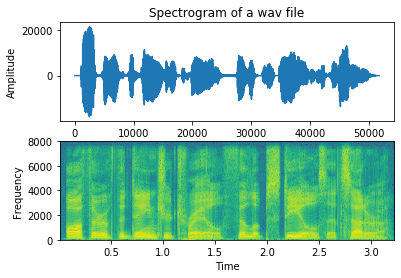

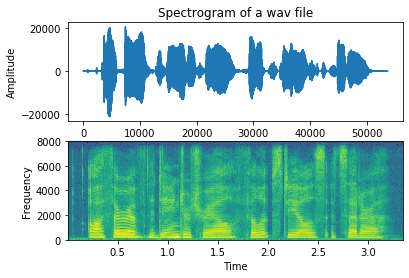

In [75]:
show_files(
    [DATASET_SOURCE+'/arctic_a0001.wav', 
     DATASET_DEST+'/arctic_a0001.wav'])

# 3.0 Data Import